### About Mask R-CNN
The Mask R-CNN model addresses one of the most difficult computer vision challenges: image segmentation. Image segmentation is the task of detecting and distinguishing multiple objects within a single image. In particular, Mask R-CNN performs "instance segmentation," which means that different instances of the same type of object in the input image, for example, car, should be assigned distinct labels.

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free Cloud TPU</h3>
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   2. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Download the source code
Download the source code of the Mask R-CNN model.

In [1]:
!git clone https://github.com/rwightman/posenet-python.git
!git clone https://github.com/tensorflow/tpu/
!git clone https://github.com/MurphyJUAN/Hourse-Pose-Estimation.git
# %cd /content/posenet-python

!pip install tensorflow-gpu 
!pip install scipy 
!pip install pyyaml 
!pip install opencv-python==3.4.5.20
%tensorflow_version 1.x


Cloning into 'posenet-python'...
remote: Enumerating objects: 119, done.
remote: Total 119 (delta 0), reused 0 (delta 0), pack-reused 119
Receiving objects: 100% (119/119), 36.55 KiB | 1.59 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Cloning into 'tpu'...
remote: Enumerating objects: 9576, done.
remote: Total 9576 (delta 0), reused 0 (delta 0), pack-reused 9576
Receiving objects: 100% (9576/9576), 24.18 MiB | 27.48 MiB/s, done.
Resolving deltas: 100% (6862/6862), done.
Cloning into 'Hourse-Pose-Estimation'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 349 (delta 1), reused 8 (delta 1), pack-reused 341
Receiving objects: 100% (349/349), 73.30 MiB | 39.23 MiB/s, done.
Resolving deltas: 100% (145/145), done.
     |████████████████████████████████| 320.4MB 52kB/s 
     |████████████████████████████████| 25.4MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5,

# New Section

## Import libraries

In [2]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

## Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [3]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [6]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint
 
  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)
 
  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.51.230.114:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 12287147650458118832),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8017733462156041295),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17003261867323468366),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4748812738179498320),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 989148058071559702),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9774568508552706306),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 221331834471357577),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4664345558749079166),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 139707711081740

## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

In [ ]:
!mkdir share_folder

--2020-10-08 15:42:23--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1360583 (1.3M) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   1.30M  7.86MB/s    in 0.2s    

2020-10-08 15:42:23 (7.86 MB/s) - ‘test.jpg’ saved [1360583/1360583]



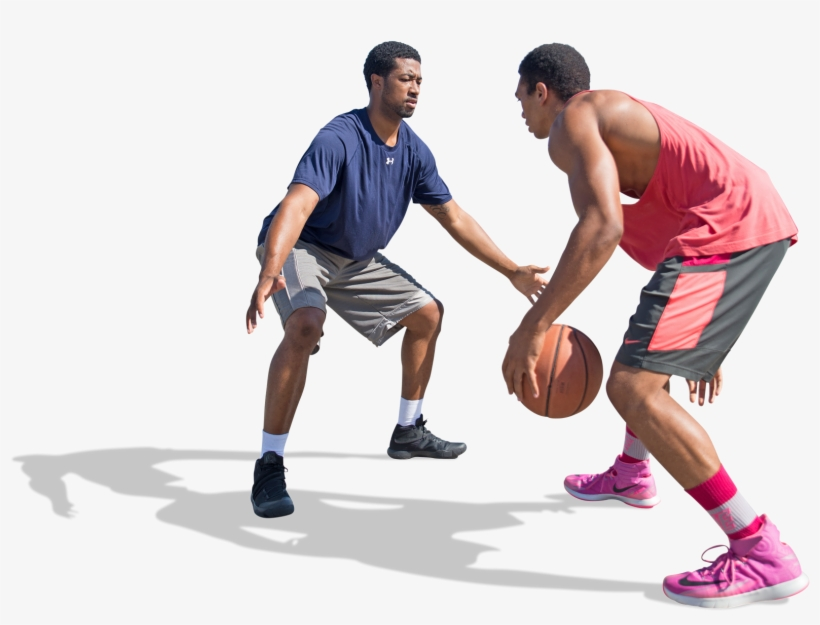

In [53]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
# !mkdir share_folder  # sa
# image_path = 'test.jpg'
image_path = '/content/Hourse-Pose-Estimation/data/images/basketball.png'
 
with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])

image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
 
display.display(display.Image(image_path, width=1024))

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [54]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Function define

In [137]:
import matplotlib.pyplot as plt
import cv2
# %matplotlib inline
def maskRCNN_humantojpg(image_path):
  
  with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])

  image = Image.open(image_path)
  # plt.imshow(image)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

  num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})
 
  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width) # 所有在coco dataset內的物件

  per_index = np.where(detection_classes == 1)[0].tolist()
  # detection_boxes[per_index] is person 
  for i in range(len(per_index)):
    index = detection_boxes[per_index][i].astype(np.uint16)
    print(len(per_index))
  # print(np.shape(segmentations[0]))
    mas = segmentations[i][index[0]:index[2], index[1]:index[3]] 
  
    new_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
  
  
    pic = new_image[index[0]:index[2], index[1]:index[3]]

    seg_pic=cv2.add(pic, np.zeros(np.shape(pic), dtype=np.uint8), mask=mas)

    image_name = image_path.split("/")[-1][:-4]
    save_path = '/content/share_folder/'
    save_name = save_path+image_name+'_'+str(i)+'.jpg'
    print(save_name)
    save_tick = cv2.imwrite(save_name, seg_pic[...,::-1])

    if save_tick:
      print('image save in:', save_name)  

In [140]:
# !rm -f /content/output_image/*
# !rm -f /content/share_folder/*

In [138]:
%cd /content/
maskRCNN_humantojpg('/content/Hourse-Pose-Estimation/data/images/basketball.png')

/content
2
/content/share_folder/basketball_0.jpg
image save in: /content/share_folder/basketball_0.jpg
2
/content/share_folder/basketball_1.jpg
image save in: /content/share_folder/basketball_1.jpg


In [139]:
%cd /content/posenet-python
!python3 image_demo.py --model 101 --image_dir /content/share_folder --output_dir /content/output_image

/content/posenet-python

2020-10-08 16:32:11.125638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-08 16:32:11.135960: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-08 16:32:11.136026: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9395487cea46): /proc/driver/nvidia/version does not exist
2020-10-08 16:32:11.142882: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-10-08 16:32:11.143159: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2df0a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-08 16:32:11.143200: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version



Results for image: /content/share_

## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [55]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})
 
num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [56]:
per_index = np.where(detection_classes == 1)[0].tolist()
detection_boxes[per_index] # is person
index = detection_boxes[per_index][0].astype(np.uint16)

In [62]:
%cd /content/

/content


In [63]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
 
mas = segmentations[0][index[0]:index[2], index[1]:index[3]]

new_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
 
# plt.imshow(new_image)
pic = new_image[index[0]:index[2], index[1]:index[3]]

seg_pic=cv2.add(pic, np.zeros(np.shape(pic), dtype=np.uint8), mask=mas)

cv2.imwrite('./share_folder/person.jpg', seg_pic[...,::-1])

True

In [64]:
# plt.imshow(seg_pic)

## Visualize the detection results
Time to check out the result!

In [65]:
# max_boxes_to_draw = 50   #@param {type:"integer"}
# min_score_thresh = 0.69    #@param {type:"slider", min:0, max:1, step:0.01}
 
# image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
#     np_image,
#     detection_boxes,
#     detection_classes,
#     detection_scores,
#     category_index,
#     instance_masks=segmentations,
#     use_normalized_coordinates=False,
#     max_boxes_to_draw=max_boxes_to_draw,
#     min_score_thresh=min_score_thresh)
# output_image_path = 'test_results.jpg'
# Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
# display.display(display.Image(output_image_path, width=1024))

## PoseNet main
輸出會放在output_image folder中

In [66]:

%cd /content/posenet-python
!python3 image_demo.py --model 101 --image_dir /content/share_folder --output_dir /content/output_image

/content/posenet-python

2020-10-08 16:05:28.269123: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-08 16:05:28.279751: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-08 16:05:28.279821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9395487cea46): /proc/driver/nvidia/version does not exist
2020-10-08 16:05:28.287197: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-10-08 16:05:28.287580: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x31baa00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-08 16:05:28.287633: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version



Results for image: /content/share_